In [ ]:
! git clone https://github.com/pymgrit/pymgrit.git

Cloning into 'pymgrit'...
remote: Enumerating objects: 5926, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 5926 (delta 184), reused 245 (delta 131), pack-reused 5584
Receiving objects: 100% (5926/5926), 47.29 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (4265/4265), done.


In [ ]:
! pip3 install pymgrit/.

Processing ./pymgrit
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached mpi4py-3.1.1.tar.gz (2.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pymgrit: filename=pymgrit-1.0.5-py3-none-any.whl size=61890 sha256=cb091f9b4cce2d27ea1b4b2a80656c1c1beafd182fdaa7d3c79dc5cff2cf7288
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ypr5h7l/wheels/9d/7b/04/249143b717b02339e5984ae30f2fd3eaf389d19a03356ced82
  ERROR: Command errored out with exit status 1:
   command: /root/venv/bin/python /root/venv/lib/python3.7/site-packages/pip/_vendor/p

In [ ]:
from pymgrid import MicrogridGenerator as mg

m_gen=mg.MicrogridGenerator()
m_gen.generate_microgrid()

ModuleNotFoundError: No module named 'pymgrid'

In [ ]:
m_gen.microgrids[0].get_control_info()

AttributeError: 'Microgrid' object has no attribute 'get_control_info'

In [ ]:
from pymgrid.Environments.pymgrid_cspla import MicroGridEnv
from pymgrid import MicrogridGenerator as m_gen

#these line will create a list of microgrid
env = m_gen.MicrogridGenerator(nb_microgrid=25)
pymgrid25 = env.load('pymgrid25')
mg = pymgrid25.microgrids

#you can pass any of the microgrid to environment class:
env = MicroGridEnv({'microgrid':mg[0]})

#example of codes to to interact with the environment:
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = #your algorithm to select the next action
    obs, reward, done, info = env.step(action)
    episode_reward += reward

SyntaxError: invalid syntax (2413870867.py, line 17)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
from scipy.integrate import odeint

## 1. Lorenz System Generator

In [ ]:
def f(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

In [ ]:
def benchmarkData():
    #timestep = 0.01  # typical time difference mentioned in Shimada&Nagashima(1979)
    timestep = 0.01
    size = 16000

    np.random.seed(42)
    state0 = np.random.uniform(-1,1,(3)).tolist()
    t = np.arange(0.0, timestep*size, timestep)

    states = odeint(f, state0, t)
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.gca(projection="3d")
    ax.plot(states[:, 0], states[:, 1], states[:, 2], linewidth=0.3)
    ax.xaxis.set_label_text('x')
    ax.yaxis.set_label_text('y')
    ax.zaxis.set_label_text('z')
    plt.draw()
    plt.show()
    return states, timestep

## 2. Model

### 2.1 Knowledge-based Model

In [ ]:
class KnowledgeModel:
    def __init__(self, a, b, c, error, timestep):
        self.a = a
        self.b = b
        self.c = c
        self.epsilon = error
        self.dt = timestep
        self.state = np.zeros(3)

    def update(self, prev):
        self.state[0] = prev[0] + (prev[1]-prev[0])*self.a*self.dt
        self.state[1] = prev[1] + (prev[0]*((self.b+self.epsilon)-prev[2])-prev[1])*self.dt
        self.state[2] = prev[2] + (prev[0]*prev[1]-self.c*prev[2])*self.dt

    def getState(self):
        return self.state

### 2.2 ESN and Hybrid Model

In [ ]:
class Model:
    def __init__(self, knowledgeParam, phaseLen, rho, sigma, lamda, size, hybrid=True):
        np.random.seed(215213)

        #setting and hyperparams
        self.initLen = phaseLen[0] # washout phase
        self.trainLen = phaseLen[1]
        self.testLen = phaseLen[2]
        self.rho = rho # spectral radius
        self.sigma = sigma # input scale
        self.lamda = lamda # coefficient of regularization
        self.inSize = size[0]
        self.resSize = size[1]
        self.outSize = size[2]
        self.hybrid = hybrid
        self.KM = KnowledgeModel(**knowledgeParam) if self.hybrid else None

        #model
        self.Win = (np.random.rand(self.resSize,1 + self.inSize + self.hybrid * self.inSize) - 0.5) * 2 * self.sigma
        self.W = np.random.rand(self.resSize, self.resSize) - 0.5
        self.W = self.W/max(abs(linalg.eig(self.W)[0]))*self.rho
        self.Wout =  np.zeros((self.resSize, 1 + self.inSize + self.resSize + self.hybrid*self.inSize))
    
    def fit(self, u, y):
        x = np.zeros((self.resSize, 1))
        X = np.zeros((1 + self.hybrid * self.inSize + self.resSize, self.trainLen)) 
        Yt = y[None, self.initLen:self.trainLen+self.initLen].squeeze().T
        for t in range(self.trainLen+self.initLen):
            ut = u[t].reshape(-1,1)
            if self.hybrid:
                self.KM.update(ut)
                kt = self.KM.getState().reshape(-1,1)
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut, kt))) + np.dot(self.W, x))
                if t >= self.initLen:
                    X[:, t-self.initLen] = np.vstack((1, kt, x))[:, 0].reshape(self.resSize+self.inSize+1)
            else:
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut))) + np.dot(self.W, x))
                if t >= self.initLen:
                    X[:, t-self.initLen] = np.vstack((1, x))[:, 0].reshape(self.resSize+1)
        
        self.Wout = np.dot(np.dot(Yt,X.T), linalg.inv(np.dot(X,X.T) + self.lamda*np.eye(1 + self.hybrid*self.inSize + self.resSize)))
    
    def predict(self, u):
        x = np.zeros((self.resSize, 1))
        Y = np.zeros((self.outSize, self.testLen))
        ut = u[self.trainLen+self.initLen-1].reshape(-1,1)
        for t in range(self.testLen):
            if self.hybrid:
                self.KM.update(ut)
                kt = self.KM.getState().reshape(-1,1)
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut, kt))) + np.dot(self.W, x))
                Y[:, t] = np.dot(self.Wout, np.vstack((1, kt, x))).squeeze()
            else:
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut))) + np.dot(self.W, x))
                Y[:, t] = np.dot(self.Wout, np.vstack((1, x))).squeeze()
            ut = Y[:, t].reshape(-1,1) # closed loop
        return Y

    def getError(self, y, Y):
        errorLen = self.testLen
        gt = y[self.trainLen+self.initLen+1:self.trainLen+self.initLen+errorLen+1]
        pred = Y[:, 0:errorLen]
        nmse = sum(np.square(gt - pred.T)) / errorLen / np.std(gt) / np.std(gt)
        return nmse
    
    def visualize(self, y, Y):
        for i in range(self.inSize):
            plt.figure(1).clear()
            plt.plot(y[self.trainLen+self.initLen+1:self.trainLen+self.initLen+self.testLen+1, i], 'g')
            plt.plot(Y.T[:, i], 'b')
            plt.title('Target and generated signals')
            plt.legend(['Target signal', 'Free-running predicted signal'])
            plt.show()

## 3. Performance Comparison

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  if sys.path[0] == '':


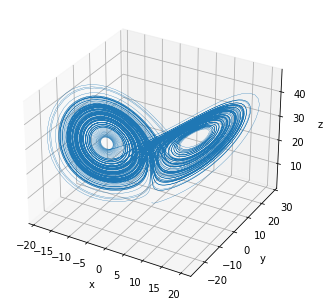

In [ ]:
# load the data
knowledge_timestep = 0.1
data, generator_timestep = benchmarkData()
data = data[::int(knowledge_timestep/generator_timestep)]
u = data[:, :] # input
y = data[1:, :] # output

In [ ]:
knowledgeParam = dict(
    a=28.0,
    b=10.0,
    c=8.0/3.0,
    error=0.,
    timestep=knowledge_timestep
)

### 3.1 Hybrid Model

[0.77808207 0.93764026 0.41349156]


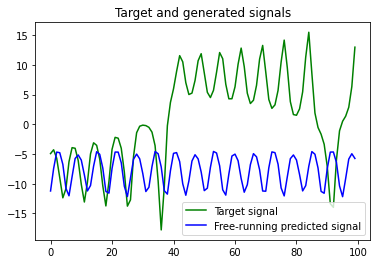

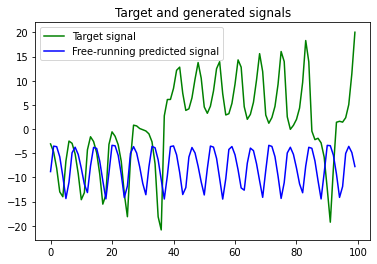

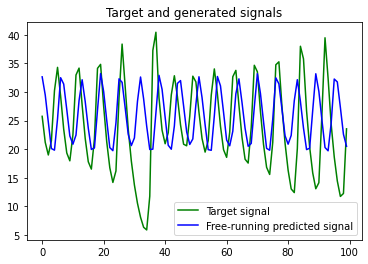

In [ ]:
model = Model(knowledgeParam, (100, 1000, 100), 0.9, 0.5, 1e-7, (3, 100, 3), hybrid = True)
model.fit(u,y)
Y = model.predict(u)
print(model.getError(y, Y))
model.visualize(y, Y)

### 3.2 ESN only

[  2.99700899   2.43049264 292.3125189 ]


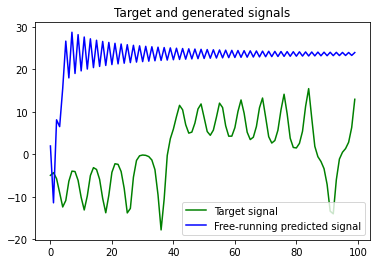

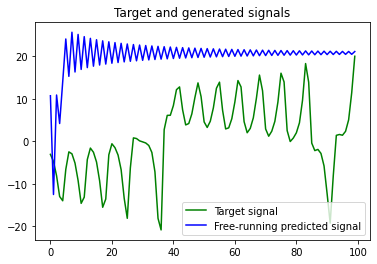

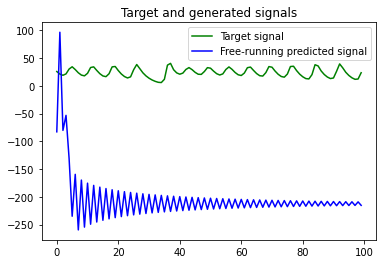

In [ ]:
model2 = Model(knowledgeParam, (100, 1000, 100), 0.9, 0.5, 1e-7, (3, 1000, 3), hybrid = False)
model2.fit(u,y)
Y = model2.predict(u)
print(model2.getError(y, Y))
model2.visualize(y, Y)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2728d440-5ff4-4e65-a400-4cda139b052c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>